# Setup

In [1]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
import os

## short tutorial: How to profile the time of cell

In [2]:
%load_ext snakeviz

In [3]:
#import glob

In [4]:
#%%prun -D program.prof
#files = glob.glob('*.txt')
#for file in files:
#    with open(file) as f:
#        print(hashlib.md5(f.read().encode('utf-8')).hexdigest())

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
res_a = {"000000101000": 5602, "000000101010": 1575, "000000000000": 742, "000000101001": 56, "000000000010": 195, "000000101011": 12, "000000000001": 9, "000000000011": 1}
res_b = {"000000000001": 4, "000000101010": 1588, "000000101000": 5535, "000000000011": 2, "000000000000": 767, "000000000010": 219, "000000101001": 60, "000000101011": 17}

In [7]:
res_unif = {
    '000000000000': 1024,
    '000000000001': 1024,
    '000000000010': 1024,
    '000000000011': 1024,
    '000000101000': 1024,
    '000000101001': 1024,
    '000000101010': 1024,
    '000000101011': 1024
}

In [8]:
from inspector import convert_dict_to_df
from detectors import obtain_raw_samples
from detectors import obtain_multivariate_samples

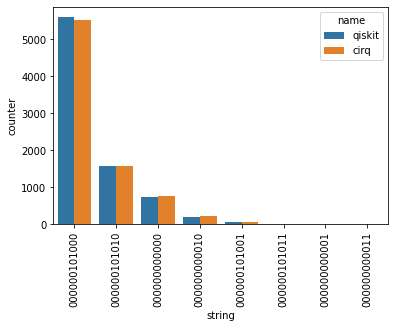

In [9]:
df = convert_dict_to_df(
    res_a, res_b, platform_a='qiskit', platform_b='cirq'
)
sns.barplot(x="string", hue="name", y="counter", data=df, palette=["C0", "C1"])
plt.xticks(rotation=90)
plt.show()

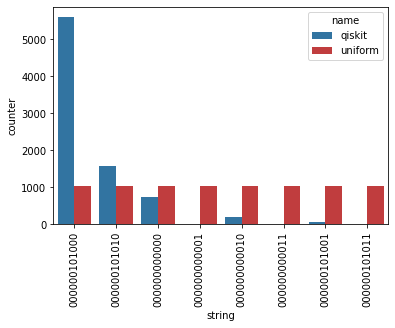

In [10]:
df = convert_dict_to_df(
    res_a, res_unif, platform_a='qiskit', platform_b='uniform'
)
sns.barplot(x="string", hue="name", y="counter", data=df, palette=["C0", "C3"])

plt.xticks(rotation=90)
plt.show()

In [11]:
sample_a = obtain_raw_samples(res_a)
sample_b = obtain_raw_samples(res_b)
sample_unif = obtain_raw_samples(res_unif)

In [12]:
sample_a_mv = obtain_multivariate_samples(res_a)
sample_b_mv = obtain_multivariate_samples(res_b)
sample_unif_mv = obtain_multivariate_samples(res_unif)

# KS Test
- "Two arrays of sample observations assumed to be drawn from a continuous distribution, sample sizes can be different."
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html



In [27]:
from scipy.stats import ks_2samp
from scipy.stats import kstest # alias

ks_2samp(sample_a, sample_b)
# kstest(sample_a, sample_b)

KstestResult(statistic=0.0054931640625, pvalue=0.9996709858409564)

In [28]:
ks_2samp(sample_a, sample_unif)

KstestResult(statistic=0.3843994140625, pvalue=0.0)

# Anderson K-samples Test


## Single Sample case
According to [Wikipedia](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test), it is equivalent to [Cramér–von Mises criterion](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion) which is based on empiraical distribution functions (edf).
"Thus, compared with the Cramér–von Mises distance, the Anderson–Darling distance places more weight on observations in the tails of the distribution." [Wikipedia](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test)
**we use k-sample so this is not applicable**


Even if the scipy doc mentions categoritcal, I am not sure that the [actual implementation](https://github.com/scipy/scipy/blob/v1.7.1/scipy/stats/morestats.py#L2130) uses the categorical coefficients mentioned in the seminal [paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1087.8833&rep=rep1&type=pdf) ("K-Sample Anderson-Darling Tests", 1987).

I suspect there is another formula with other coefficeints (in table 3 of the same paper) to use.

In [35]:
from scipy.stats import anderson_ksamp
anderson_ksamp([sample_a, sample_b])

/tmp/ipykernel_33745/2634588702.py:2: UserWarning: p-value capped: true value larger than 0.25
  anderson_ksamp([sample_a, sample_b])


Anderson_ksampResult(statistic=-1.0879497538259495, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

In [29]:
anderson_ksamp([sample_a, sample_unif])

/tmp/ipykernel_33745/1983452767.py:1: UserWarning: p-value floored: true value smaller than 0.001
  anderson_ksamp([sample_a, sample_unif])


Anderson_ksampResult(statistic=704.3506103350016, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

# Energy Test
Assumptions: multivariate data

In [13]:
import torch
from torch_two_sample import statistics_diff

In [11]:
torch_sample_1 = torch.from_numpy(sample_a_mv)
torch_sample_2 = torch.from_numpy(sample_b_mv)
energy_test = statistics_diff.EnergyStatistic(len(sample_a_mv), len(sample_b_mv))
statistics, dist_matrix = energy_test.__call__(torch_sample_1, torch_sample_2, ret_matrix=True)
dist_matrix = dist_matrix.to(torch.float32)
p_value = energy_test.pval(dist_matrix, n_permutations=10)
print("statistics:", statistics)
print("p-value:", p_value)

statistics: tensor(0.0001)
p-value: 1.0


In [78]:
%%prun -D program.prof

torch_sample_1 = torch.from_numpy(sample_a_mv)
torch_sample_2 = torch.from_numpy(sample_unif_mv)  # <-- NOTE CHANGE
energy_test = statistics_diff.EnergyStatistic(len(sample_a_mv), len(sample_unif_mv))  # <-- NOTE CHANGE
statistics, dist_matrix = energy_test.__call__(torch_sample_1, torch_sample_2, ret_matrix=True)
#p_value = energy_test.pval(dist_matrix, n_1=len(sample_a_mv), n_2=len(sample_unif_mv), n_permutations=10)
print("statistics:", statistics)
print("p-value:", p_value)

statistics: tensor(0.6891)
p-value: None
 
*** Profile stats marshalled to file 'program.prof'. 


In [19]:
dist_matrix.shape

(16384, 16384)

In [56]:
dist_matrix

array([[0.00316228, 0.00316228, 0.00316228, ..., 1.4142171 , 1.4142171 ,
        1.4142171 ],
       [0.00316228, 0.00316228, 0.00316228, ..., 1.4142171 , 1.4142171 ,
        1.4142171 ],
       [0.00316228, 0.00316228, 0.00316228, ..., 1.4142171 , 1.4142171 ,
        1.4142171 ],
       ...,
       [1.4142171 , 1.4142171 , 1.4142171 , ..., 0.00316228, 0.00316228,
        0.00316228],
       [1.4142171 , 1.4142171 , 1.4142171 , ..., 0.00316228, 0.00316228,
        0.00316228],
       [1.4142171 , 1.4142171 , 1.4142171 , ..., 0.00316228, 0.00316228,
        0.00316228]], dtype=float32)

In [20]:
dist_matrix[:100, :100].shape

(100, 100)

<AxesSubplot:>

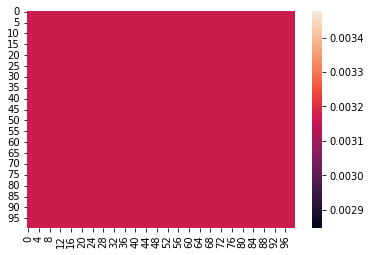

In [21]:
sns.heatmap(
    data=dist_matrix[:100, :100]
)

In [45]:
dist_matrix[0][1]

0.0031622776

In [39]:
%%prun -D program.prof
p_value = my_pval(dist_matrix, n_1=len(sample_a_mv), n_2=len(sample_unif_mv), n_permutations=10)

 
*** Profile stats marshalled to file 'program.prof'. 


In [34]:
sample_a_mv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [36]:
keys, values = zip(*res_a.items())
keys

('000000101000',
 '000000101010',
 '000000000000',
 '000000101001',
 '000000000010',
 '000000101011',
 '000000000001',
 '000000000011')

In [37]:
values

(5602, 1575, 742, 56, 195, 12, 9, 1)

In [ ]:
def unique_multivariates_and_frequencies(result_dictionary):
    """Return keys as multivariate vectors and their frequecies."""
    keys, frequencies = zip(*result_dictionary.items())
    multivariate_keys = np.vstack([
        np.array([int(x) for x in bin_string])
        for bin_string in keys
    ])
    return multivariate_keys, frequencies


def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    r"""Compute the matrix of all squared pairwise distances.
    Arguments
    ---------
    sample_1 : torch.Tensor or Variable
        The first sample, should be of shape ``(n_1, d)``.
    sample_2 : torch.Tensor or Variable
        The second sample, should be of shape ``(n_2, d)``.
    norm : float
        The l_p norm to be used.
    Returns
    -------
    torch.Tensor or Variable
        Matrix of shape (n_1, n_2). The [i, j]-th entry is equal to
        ``|| sample_1[i, :] - sample_2[j, :] ||_p``."""
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)
    
    
def increase_dimension(small_matrix, record_frequencies):
    """Duplicate row and column based on the frquencies.
    
    Note that record_frequencies contains record like:
    
    7: 128, 
    
    which means that the row and column 7 have to be replicated 128 times,
    vertically and horizontally respectively.
    """
    repeat_tensor = torch.tensor(np.array(record_frequencies))
    print(repeat_tensor)
    small_matrix = torch.repeat_interleave(small_matrix, repeat_tensor, dim=1)
    small_matrix = torch.repeat_interleave(small_matrix, repeat_tensor, dim=0)
    print(small_matrix)
    return small_matrix
        
    
    
def energy_call(res_1, res_2):
    
        values_1, freq_1 = unique_multivariates_and_frequencies(result_dictionary=res_1)
        values_2, freq_2 = unique_multivariates_and_frequencies(result_dictionary=res_2)
        
        
        values_1 = torch.from_numpy(values_1)
        values_2 = torch.from_numpy(values_2)
        sample_12 = torch.cat((values_1, values_2), 0)
        
        small_matrix = pdist(sample_12, sample_12, norm=2)
        distances = increase_dimension(
            small_matrix=small_matrix, 
            record_frequencies=np.hstack((np.array(freq_1), np.array(freq_2))))
        #distances = pdist(sample_12, sample_12, norm=2)

        n_1 = sum(freq_1)
        print("n_1:", n_1)
        n_2 = sum(freq_2)
        a00 = - 1. / (n_1 * n_1)
        a11 = - 1. / (n_2 * n_2)
        a01 = 1. / (n_1 * n_2)
        print("a00:", a00)
        print("a11:", a11)
        print("a01:", a01)
        
        d_1 = distances[:n_1, :n_1].sum()
        d_2 = distances[-n_2:, -n_2:].sum()
        d_12 = distances[:n_1, -n_2:].sum()
        print("d_1:", d_1)
        print("d_2:", d_2)
        print("d_12:", d_12)

        loss = 2 * a01 * d_12 + a00 * d_1 + a11 * d_2
        print("loss:", loss)
        print(type(loss))
        return loss

In [75]:
import numba
import numpy as np
from numba import jit

@jit(nopython=True)
def permutation_test_mat(matrix: np.ndarray,
                         n_1: int , n_2: int, n_permutations: int,
                         a00: float=1, a11: float=1, a01: float=0):
    """Compute the p-value of the following statistic (rejects when high)
        \sum_{i,j} a_{\pi(i), \pi(j)} matrix[i, j].
    """
    n = n_1 + n_2
    pi = np.zeros(n, dtype=np.int8)
    pi[n_1:] = 1

    statistic = 0
    larger = 0.
    count = 0
    i = 0
    j = 0
    #cdef float mij
    #cdef int sample_n
    for sample_n in range(1 + n_permutations):
        count = 0.
        for i in range(n):
            for j in range(i, n):
                mij = matrix[i, j] + matrix[j, i]
                if pi[i] == 0 and pi[j] == 0:
                    count += a00 * mij
                elif pi[i] == 1 and pi[j] == 1:
                    count += a11 * mij
                else:
                    count += a01 * mij
        if sample_n == 0:
            statistic = count
        elif statistic <= count:
            larger += 1

        np.random.shuffle(pi)

    return larger / n_permutations


@jit(nopython=True)
def my_pval(distances, n_1, n_2, n_permutations=1000):
    a00 = - 1. / (n_1 * n_1)
    a11 = - 1. / (n_2 * n_2)
    a01 = 1. / (n_1 * n_2)
    permutation_test_mat(
        distances,
        n_1, n_2,
        n_permutations,
        a00=a00, a11=a11, a01=a01)

In [79]:
%%prun -D program.prof
distances = energy_call(res_1=res_a, res_2=res_unif)

tensor([5602, 1575,  742,   56,  195,   12,    9,    1, 1024, 1024, 1024, 1024,
        1024, 1024, 1024, 1024])
tensor([[0.0032, 0.0032, 0.0032,  ..., 1.4142, 1.4142, 1.4142],
        [0.0032, 0.0032, 0.0032,  ..., 1.4142, 1.4142, 1.4142],
        [0.0032, 0.0032, 0.0032,  ..., 1.4142, 1.4142, 1.4142],
        ...,
        [1.4142, 1.4142, 1.4142,  ..., 0.0032, 0.0032, 0.0032],
        [1.4142, 1.4142, 1.4142,  ..., 0.0032, 0.0032, 0.0032],
        [1.4142, 1.4142, 1.4142,  ..., 0.0032, 0.0032, 0.0032]])
n_1: 8192
a00: -1.4901161193847656e-08
a11: -1.4901161193847656e-08
a01: 1.4901161193847656e-08
d_1: tensor(40122380.)
d_2: tensor(86366544.)
d_12: tensor(86366624.)
loss: tensor(0.6891)
<class 'torch.Tensor'>
 
*** Profile stats marshalled to file 'program.prof'. 


In [71]:
2 + 1.4901161193847656e-08 * 40122380 + -1.4901161193847656e-08 * 40122380 + -1.4901161193847656e-08 * 40122380

1.4021299481391907

In [55]:
distances.shape

torch.Size([16384, 16384])

In [52]:

statistics= energy_call(res_1=res_a, res_2=res_b)
statistics

tensor([5602, 1575,  742,   56,  195,   12,    9,    1, 5602, 1575,  742,   56,
         195,   12,    9,    1])
tensor([[0.0032, 0.0032, 0.0032,  ..., 1.7321, 1.7321, 2.0000],
        [0.0032, 0.0032, 0.0032,  ..., 1.7321, 1.7321, 2.0000],
        [0.0032, 0.0032, 0.0032,  ..., 1.7321, 1.7321, 2.0000],
        ...,
        [1.7321, 1.7321, 1.7321,  ..., 0.0032, 0.0032, 1.0000],
        [1.7321, 1.7321, 1.7321,  ..., 0.0032, 0.0032, 1.0000],
        [2.0000, 2.0000, 2.0000,  ..., 1.0000, 1.0000, 0.0032]])


tensor(0.)

In [50]:
statistics= energy_call(res_1=res_a, res_2=res_unif)
statistics

tensor([5602, 1575,  742,   56,  195,   12,    9,    1, 5602, 1575,  742,   56,
         195,   12,    9,    1])
tensor([[0., 5., 3., 3., 3., 3., 1., 2.],
        [5., 0., 2., 2., 2., 2., 4., 7.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [1., 4., 2., 2., 2., 2., 0., 3.],
        [2., 7., 5., 5., 5., 5., 3., 0.]])


tensor(0.)

## Experiment

In [22]:
t = torch.rand(4,1)
print(t)
tr = t.repeat(1, 3)
print(tr)

tensor([[0.5580],
        [0.0469],
        [0.1790],
        [0.3435]])
tensor([[0.5580, 0.5580, 0.5580],
        [0.0469, 0.0469, 0.0469],
        [0.1790, 0.1790, 0.1790],
        [0.3435, 0.3435, 0.3435]])


In [25]:
X = torch.FloatTensor([
    [0,5,3,1,2],
    [5,0,2,4,7],
    [3,2,0,2,5],
    [1,4,2,0,3],
    [2,7,5,3,0]
])

In [33]:
num_repeats = 2
repeat_tensor = torch.tensor(num_repeats).to(X.device, torch.int64)
repeat_tensor = torch.tensor(np.array([1,1,4,1,1]))
print(repeat_tensor)
X_dup_col = torch.repeat_interleave(X, repeat_tensor, dim=1)
X_dup_all = torch.repeat_interleave(X_dup_col, repeat_tensor, dim=0)
print(X_dup_all)

tensor([1, 1, 4, 1, 1])
tensor([[0., 5., 3., 3., 3., 3., 1., 2.],
        [5., 0., 2., 2., 2., 2., 4., 7.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [3., 2., 0., 0., 0., 0., 2., 5.],
        [1., 4., 2., 2., 2., 2., 0., 3.],
        [2., 7., 5., 5., 5., 5., 3., 0.]])
